In [7]:
# Imports
import qiskit
import pennylane as qml
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

In [35]:
qiskit.IBMQ.save_account('your_token', overwrite=True)

In [36]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [37]:
n_wires = 1
n_qubits = 1
provider = qiskit.IBMQ.get_provider('ibm-q') # select the provider
backend = provider.get_backend('ibmq_lima') # select the name of the quatum computer to use
print("real device:", backend.name())
#dev = qml.device('qiskit.ibmq', wires=n_wires, backend=backend.name(), provider=provider)
dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

real device: ibmq_lima


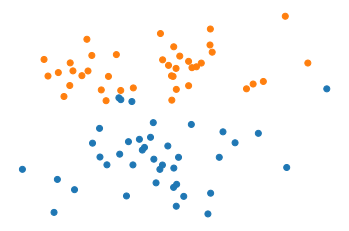

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

x, y = make_classification(n_samples=80, n_classes=2, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

In [59]:
# Convert quantum layer to keras
n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [60]:
# Define classical layers
clayer_1 = tf.keras.layers.Dense(1)
clayer_2 = tf.keras.layers.Dense(1, activation="sigmoid")

In [62]:
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
fitting = model.fit(x, y_hot, epochs=4, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/4
12/12 - 4s - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/4
12/12 - 2s - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/4
12/12 - 2s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/4
12/12 - 2s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


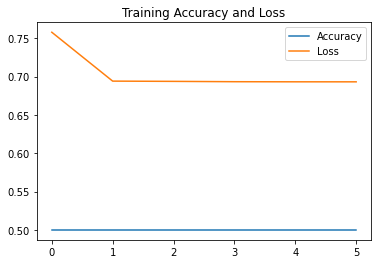

In [50]:
plt.plot(fitting.history['accuracy'], label='Accuracy')
plt.plot(fitting.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('Training Accuracy and Loss')
plt.show()

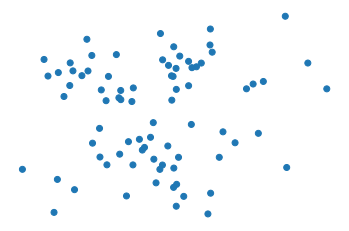

In [51]:
y_prob = model.predict(x)
y_class = y_prob.argmax(axis=-1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y_class]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()